# Import

In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Activation, Add, Flatten
from keras import models, layers, initializers
from keras.models import Model, Sequential
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from skimage.color import hsv2rgb
import time
from PIL import Image
import math


Using TensorFlow backend.


# Image Size

In [2]:
xDim = 1080
yDim = 720

# Create Grid

In [3]:
def createGrid(xDim, yDim, scale = 1.0):
    
    N = np.mean((xDim, yDim))
    x = np.linspace(- xDim / N * scale, xDim / N * scale, xDim)
    y = np.linspace(- yDim / N * scale, yDim / N * scale, yDim)

    X, Y = np.meshgrid(x, y)

    x = np.ravel(X).reshape(-1, 1)
    y = np.ravel(Y).reshape(-1, 1)
    r = np.sqrt(x ** 2 + y ** 2)

    return x, y, r

# Define Model



In [12]:
def generatorNetwork(inputShape = (4, ), channelSize = 3, networkDepth = 4, activation = 'tanh', units = 32):
    
        xInput = Input(shape = inputShape, name = "xInput")
        
        x = Dense(units, activation = activation, name = "Dense1")(xInput)
        
        for i in range (networkDepth):
            x = Dense(units, activation = activation, name = "Dense" + str(i + 2))(x)

        
        outputLayer = Dense(channelSize, activation = 'sigmoid', name = "OutputSigmoid")(x)
        
        model = Model(inputs = [xInput], outputs = outputLayer)
        
        model.compile(optimizer = 'rmsprop', loss = 'mse')
        
        return model
    

In [59]:
def generatorNetworkTwo(variance, inputShape = (4, ), channelSize = 3, networkDepth = 4, activation = 'tanh', units = 32):
    
        init = initializers.VarianceScaling(scale = variance)
        
        xInput = Input(shape = inputShape, name = "xInput")
        x = Dense(units, kernel_initializer = init, activation = activation, name = "Dense1")(xInput)
        
        for i in range (networkDepth):
            x = Dense(units, kernel_initializer = init, activation = activation, name = "Dense" + str(i + 2))(x)

        outputLayer = Dense(channelSize, activation = 'tanh', name = "OutputSigmoid")(x)
        
        model = Model(inputs = [xInput], outputs = outputLayer)
        
        model.compile(optimizer = 'rmsprop', loss = 'mse')
        
        return model
    

In [46]:
model = generatorNetwork(networkDepth = 6)
modelTwo = generatorNetworkTwo(variance = np.random.uniform(50, 150))
model.summary()
modelTwo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xInput (InputLayer)          (None, 4)                 0         
_________________________________________________________________
Dense1 (Dense)               (None, 32)                160       
_________________________________________________________________
Dense2 (Dense)               (None, 32)                1056      
_________________________________________________________________
Dense3 (Dense)               (None, 32)                1056      
_________________________________________________________________
Dense4 (Dense)               (None, 32)                1056      
_________________________________________________________________
Dense5 (Dense)               (None, 32)                1056      
_________________________________________________________________
Dense6 (Dense)               (None, 32)                1056      
__________

# Create Image

In [42]:
def createImage(model, x, xDim, y, yDim, r):
    
    latentSpace = np.random.normal(0, 1, 1)
    Z = np.repeat(latentSpace, x.shape[0]).reshape(-1, x.shape[0])
    X = np.concatenate([x, y, r, Z.T], axis = 1)
        
    pred = model.predict(X)
    
    image = []
    channels = pred.shape[1]
    
    for channel in range(channels):
        
        # Select One Chanel
        yp = pred[:, channel]
        
        # Normalize Values
        yp = (yp - yp.min()) / (yp.max() - yp.min())
        
        image.append(yp.reshape(yDim, xDim))
    
    # Stack Along Depth (3rd Axis)
    image = np.dstack(image)

    if channels == 3: 
        image = hsv2rgb(image)
    
    image = (image * 255).astype(np.uint8)

    return image

# Helper Functions

In [7]:
def plotImages(images):
     
    n = min(len(images), 9)
    rows = int(math.sqrt(n))
    cols = n // rows
    
    fig = plt.figure()
    for i in range(1, n + 1):
        image = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(image)
        
    plt.show()

In [8]:
def saveImage(image, resultDir, fileNumber):
    
    if not os.path.exists(resultDir):
        os.makedirs(resultDir)

    imageName = "img" + str(fileNumber) + ".png"
    imagePath = os.path.join(resultDir, imageName)
    file = Image.fromarray(image)
    file.save(imagePath)    
    
    return imagePath

# Run

<h4> Model One

In [62]:
images = []
numberOfImages = 10

for i in tqdm(range(numberOfImages)):
    
    x, y, r = createGrid(xDim, yDim, 1.0)
    model = generatorNetwork(networkDepth = 1, activation = 'relu', units = 32)

    image = createImage(model, x, xDim, y, yDim, r)
    image = image.squeeze()
    images.append(image)

    
    saveImage(image, './Images/relu-1layers-32units', i)


100%|██████████| 10/10 [04:37<00:00, 27.70s/it]


<h4> Model Two

In [63]:
images = []
numberOfImages = 10

for i in tqdm(range(numberOfImages)):
    
    x, y, r = createGrid(xDim, yDim, 1.0)
    modelTwo = generatorNetworkTwo(variance = np.random.uniform(50, 150), networkDepth = 1, units = 32)

    image = createImage(modelTwo, x, xDim, y, yDim, r)
    image = image.squeeze()
    images.append(image)

    
    saveImage(image, './Images/ModelTwo/tanh-1layers-32units-tanhOutput', i)



100%|██████████| 10/10 [04:41<00:00, 28.18s/it]


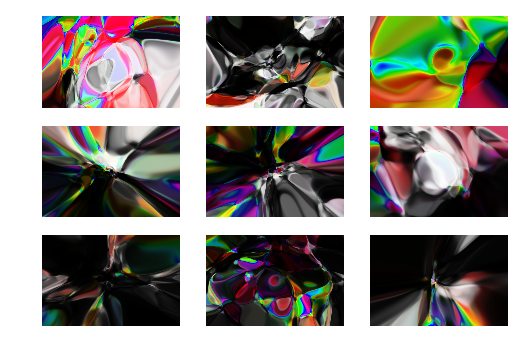

In [61]:
plotImages(images)